In [2]:
from  scipy.special import j1
from kSZ_forecast_general_func import *
from kSZ_forecast_HOD import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
Grid = 512
MAS  = "NGP"
Snapshot = 3356

snap_info=Snap_Info()

Thelen = Boxlen/h/cosmo.comoving_distance(z=snap_info.get_redshift(Snapshot)).value
cnorm=ne0*sigma_t*Mpc2m*Boxlen*1.0/Grid*(1+snap_info.get_redshift(Snapshot))**2/h  # proj mom: km/h -> dkSZ/CMB

the_los=(45)*np.pi/180
n_rsd=np.array([np.cos(the_los),np.sin(the_los),0])

n_halo =np.array([    1,     2,     3,     5,    7,     9,    30,   70])*10**-4 #8
lgM_min=np.array([12.86, 12.68, 12.55, 12.41, 12.3, 12.23, 11.82, 11.5])

snap_info.get_redshift(Snapshot)

array([0.485])

# Generate galaxy mock

In [4]:
desi_models = ["L0", "L1", "L2", "L3"]
for i in range(4):
    hod_desi = HOD_ELG_DESI(model = desi_models[i])
    galaxy_cata = GalaxyCatalogueSnapshot(redshift=snap_info.get_redshift(Snapshot), lgM_h = lgM_h, halox = halox)
    galaxy_cata.add_galaxies(hod_desi)
    richness = galaxy_cata.halo_richness
    
    filename = "halo_Temporary_storage/halos_"+str(Snapshot)+"_richness_DESI_"+desi_models[i]+".npy"
    np.save(filename, richness)
    
    

In [5]:
hsc_models = ["NB912", "NB816"]
for i in range(2):
    hod_hsc=HOD_ELG_HSC(model = hsc_models[i])
    galaxy_cata = GalaxyCatalogueSnapshot(redshift=snap_info.get_redshift(Snapshot), lgM_h = lgM_h, halox = halox)
    galaxy_cata.add_galaxies(hod_hsc)
    richness = galaxy_cata.halo_richness
    
    filename = "halo_Temporary_storage/halos_"+str(Snapshot)+"_richness_HSC_"+hsc_models[i]+".npy"
    np.save(filename, richness)

In [55]:
snap_info.get_redshift(Snapshot)

array([2.023])

# HOD class

In [3]:
halox,halov, mh =ReadHalos_np(zstep=Snapshot)
halo_mass = mh*pm
lgM_h = np.log10(halo_mass)

In [2]:
class HOD_ELG_HSC:
    def __init__(self,model="NB912"):
        if model == "NB816":
            #lgM_c = 11.75
            #lgM_min = 12.46
            #sigma_lgM = 0.06
            #alpha = 1.06
            #F_c_A = 0.13
            #F_c_B = 0.95
            #F_s = 0.98
            #f_fake = 0.172

            self.lgM_c = 12.04
            self.lgM_min = 12.61
            self.sigma_lgM = 0.4
            self.alpha = 1.03
            self.F_c_A = 0.26
            self.F_c_B = 0.37
            self.F_s = 0.54
            self.f_fake = 0.14
        if model == "NB912":
            #lgM_c = 11.93
            #lgM_min = 12.47
            #sigma_lgM = 0.13
            #alpha = 1.23
            #F_c_A = 0.14
            #F_c_B = 0.9
            #F_s = 0.73
            #f_fake = 0.128    
            #'''
            self.lgM_c = 11.91
            self.lgM_min = 12.57
            self.sigma_lgM = 0.17
            self.alpha = 1.12
            self.F_c_A = 0.26
            self.F_c_B = 0.53
            self.F_s = 0.55
            self.f_fake = 0.104
        
    def number_centrals_mean(self,lgM):
        """
        Average number of central galaxies in each halo 
        Args:
            lgM:  array of the log10 of halo mass (Msun/h)
        Returns:
            array of mean number of central galaxies
        """
        term_gaussian = self.F_c_B*(1-self.F_c_A)*np.exp(-(lgM-self.lgM_c)**2/2/self.sigma_lgM**2)
        term_step = self.F_c_A * (1+special.erf((lgM-self.lgM_c)/self.sigma_lgM))
        return term_gaussian+term_step
        
    def number_satellites_mean(self,lgM):
        """
        Average number of satellites in each halo 
        Args:
            lgM:  array of the log10 of halo mass (Msun/h)
        Returns:
            array of mean number of satellites
        """
        delta_lgM = 1
        N_sat =  self.F_s * (1+special.erf((lgM-self.lgM_min)/delta_lgM))*(10**(lgM-self.lgM_min))**self.alpha
        return N_sat
    def get_number_centrals(self, lgM):
        """
        Randomly draw the number of satellite galaxies in each halo,
        brighter than mag_faint, from a Poisson distribution
        Args:
            lgM: array of the log10 of halo mass (Msun/h)
        Returns:
            array of number of satellite galaxies
        """
        number_mean = self.number_centrals_mean(lgM)
        # draw random number from binomial distribution
        return np.random.default_rng().binomial(1, number_mean)
    def get_number_satellites(self, lgM):
        """
        Randomly draw the number of satellite galaxies in each halo,
        brighter than mag_faint, from a Poisson distribution
        Args:
            lgM: array of the log10 of halo mass (Msun/h)
        Returns:
            array of number of satellite galaxies
        """
        number_mean = self.number_satellites_mean(lgM)
        # draw random number from Poisson distribution
        return np.random.poisson(number_mean)
    

In [49]:
class HOD_ELG_DESI:
    def __init__(self,model="L0"):
        if model == "L0":
            self.lgM_c = 11.234
            self.sigma_lgM = 0.206
            self.F_c_A = 0.133
            self.F_c_B = 0.01
            self.beta_c =-0.185
            self.lgM_min = 11.69
            self.F_s = 0.015
            self.delta_lgM= 0.516
            self.alpha = 0.947
        if model == "L1":
            self.lgM_c = 11.415
            self.sigma_lgM = 0.224
            self.F_c_A = 0.091
            self.F_c_B =0.146
            self.beta_c =-0.187
            self.lgM_min = 11.668
            self.F_s = 0.012
            self.delta_lgM= 0.516
            self.alpha = 0.939
        if model == "L2":
            self.lgM_c =11.528
            self.sigma_lgM = 0.241
            self.F_c_A = 0.035
            self.F_c_B = 0.075
            self.beta_c =-0.168
            self.lgM_min = 11.723
            self.F_s = 0.005
            self.delta_lgM= 0.508
            self.alpha = 0.94
        if model == "L3":
            self.lgM_c = 11.558
            self.sigma_lgM = 0.217
            self.F_c_A = 0.01
            self.F_c_B = 0.021
            self.beta_c = -0.065
            self.lgM_min = 11.783
            self.F_s = 0.001
            self.delta_lgM= 0.492
            self.alpha = 0.95
        
        
    def number_centrals_mean(self,lgM):
        """
        Average number of central galaxies in each halo 
        Args:
            lgM:  array of the log10 of halo mass (Msun/h)
        Returns:
            array of mean number of central galaxies
        """
        term_gaussian = self.F_c_B*(1-self.F_c_A)*np.exp(-(lgM-self.lgM_c)**2/2/self.sigma_lgM**2)
        term_step = self.F_c_A * (1+special.erf((lgM-self.lgM_c)/self.sigma_lgM))*(1+10**(lgM-self.lgM_c))**self.beta_c
        return term_gaussian+term_step
        
    def number_satellites_mean(self,lgM):
        """
        Average number of satellites in each halo 
        Args:
            lgM:  array of the log10 of halo mass (Msun/h)
        Returns:
            array of mean number of satellites
        """
        N_sat =  self.F_s * (1+special.erf((lgM-self.lgM_min)/self.delta_lgM))*(10**(lgM-self.lgM_min))**self.alpha
        return N_sat
    def get_number_centrals(self, lgM):
        """
        Randomly draw the number of satellite galaxies in each halo,
        brighter than mag_faint, from a Poisson distribution
        Args:
            lgM: array of the log10 of halo mass (Msun/h)
        Returns:
            array of number of satellite galaxies
        """
        number_mean = self.number_centrals_mean(lgM)
        # draw random number from binomial distribution
        return np.random.default_rng().binomial(1, number_mean)
    def get_number_satellites(self, lgM):
        """
        Randomly draw the number of satellite galaxies in each halo,
        brighter than mag_faint, from a Poisson distribution
        Args:
            lgM: array of the log10 of halo mass (Msun/h)
        Returns:
            array of number of satellite galaxies
        """
        number_mean = self.number_satellites_mean(lgM)
        # draw random number from Poisson distribution
        return np.random.poisson(number_mean)
    

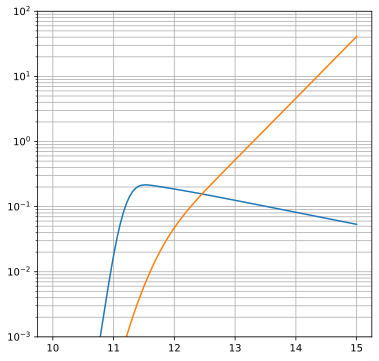

In [51]:
plt.figure(figsize=(6,6))
hod_desi = HOD_ELG_DESI(model="L0")
lgM = np.linspace(10, 15, 100)
N_cen = hod_desi.number_centrals_mean(lgM)
N_sat = hod_desi.number_satellites_mean(lgM)
plt.plot(lgM, N_cen)
plt.plot(lgM, N_sat)
plt.ylim(10**-3, 100)
plt.yscale("log")
plt.grid(which="both")

In [5]:
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw, concentration
from scipy.interpolate import RegularGridInterpolator

class GalaxyCatalogueSnapshot():
    """
    Galaxy catalogue for a simuation snapshot
    Args:
        haloes:    halo catalogue
        cosmology: object of the class Cosmology
        box_size:  comoving simulation box length (Mpc/h)
    """
    def __init__(self, redshift, lgM_h, halox, cosmo = "WMAP7"):
        self._quantities = {}
        self.redshift = redshift
        self.lgM_h = lgM_h
        self.halox = halox
        self.cosmo = cosmo
        self.size = 0
        self.N_cen = 0
        self.N_sat = 0
        cosmology.setCosmology(cosmo)
    def get(self, prop):
        """
        Get property from catalogue

        Args:
            prop: string of the name of the property
        Returns:
            array of property
        """
        return self._quantities[prop]
    def add(self, prop, value):
        """
        Add property to catalogue

        Args:
            prop:  string of the name of the property
            value: array of values of property
        """
        self._quantities[prop] = value
    def add_galaxies(self, hod):
        """
        Use hod to randomly generate galaxy absolute magnitudes.
        Adds absolute magnitudes, central index, halo index,
        and central/satellite flag to the catalogue.
        Args:
            hod: object of the class HOD
        """
        # galaxy number
        num_cen = hod.get_number_centrals(self.lgM_h)
        num_sat = hod.get_number_satellites(self.lgM_h)
        self.halo_richness = num_cen+num_sat
        self.N_cen = np.sum(num_cen)
        self.N_sat = np.sum(num_sat)
        
        # update size of catalogue
        self.size = self.N_cen + self.N_sat
        
        # add boolean array of is central galaxy
        is_cen = np.zeros(self.size, dtype="bool")
        is_cen[:self.N_cen] = True
        self.add("is_cen", is_cen)
        
        # add index of host halo in halo catalogue
        id_ = np.arange(len(self.lgM_h))
        halo_ind_cen = np.where(num_cen>0)[0]
        halo_ind_sat = np.repeat(id_, num_sat)
        halo_ind = np.concatenate([halo_ind_cen, halo_ind_sat])
        self.add("halo_ind", halo_ind)
        
        #add halo mass
        self.add("halo_mass", self.lgM_h[halo_ind])
    def nfw_interpolator(self, n_bin_lgM=100, n_bin_lgu=100, n_bin_lgr=100):
            # creates a RegularGridInterpolator object used for generating
            # random distances from haloes that follow a NFW profile
            # arrays of logM, log(u) where u is a uniform random
            cosmology.setCosmology(self.cosmo)
            lgM_s = np.linspace(10,  15, n_bin_lgM)
            conc = concentration.concentration(10**lgM_s, 'vir', self.redshift, model = 'bullock01')
            lgr_s = np.linspace(-10,  0, n_bin_lgr) #/r_vir
            lgu_s = np.linspace(-5, 0, n_bin_lgu)

            lgr_2d = np.zeros((len(lgu_s), len(lgM_s)))



            for i in range(n_bin_lgM):
                p_nfw = profile_nfw.NFWProfile(M = 10**lgM_s[i], c = conc[i], z = self.redshift, mdef = 'vir') 
                r_vir = p_nfw.RDelta(z = self.redshift, mdef = "vir") #float kpc/h
                enclose_mass = p_nfw.enclosedMass(10**lgr_s*r_vir)  #len(r), r kpc/h
                lgu = np.log10(enclose_mass/enclose_mass[-1]) #len(r)
                f = interp1d(lgu, lgr_s+np.log10(r_vir*(1+self.redshift)))
                lgr_2d[:,i] = f(lgu_s)
            xx, yy = np.meshgrid(lgM_s, lgu_s)

            f = interp2d(xx, yy, lgr_2d-3)
            f = RegularGridInterpolator((lgM_s, lgu_s), lgr_2d-3, bounds_error=False, fill_value=0)
            return f
    def get_distances(self):
            # gets random distance of satellite to central
            u = np.random.rand(self.N_sat)


            interpolator = self.nfw_interpolator()
            lgMh = self.get("halo_mass")[self.N_cen:]
            points = np.array(list(zip(self.lgM_h, np.log10(u))))
            distance = 10**interpolator(points)

            return distance
    def get_relative_positions(self):
            # relative position of galaxy to centre of halo
            pos_rel = np.zeros((self.size,3))

            # position centrals at centre of halo
            # for satellites, randomly position them around central
            # generate random x,y,z coordinates in ball
            phi = np.random.rand(self.N_sat)*2*np.pi
            sinthe = np.random.rand(self.N_sat)*2-1
            costhe = np.sqrt(1-sinthe**2)

            pos_rel[self.N_cen:,0] = np.cos(phi)*costhe
            pos_rel[self.N_cen:,0] = np.sin(phi)*costhe
            pos_rel[self.N_cen:,0] = sinthe

            #scale pos_rel so the distance is correct
            dist_sat = self.get_distances()
            for i in range(3):
                pos_rel[self.N_cen:,i] = pos_rel[self.N_cen:,i]*dist_sat

            return pos_rel
    def position_galaxies(self):
            """
            Position galaxies in haloes and give them random line of sight
            velocities. Centrals are positioned at the centre of the halo,
            satellites are positioned randomly following a NFW profile.
            Adds ra, dec, cosmological redshift and observed redshift
            to the catalogue.
            """
            pos_rel = self.get_relative_positions()
            halo_ind = self.get("halo_ind")
            pos_galaxy = self.halox[halo_ind,:]+pos_rel
            self.add("gal_pos_rel", pos_rel)
            self.add("gal_pos", pos_galaxy)

hod=HOD_ELG_HSC()
galaxy_cata = GalaxyCatalogueSnapshot(redshift=2, lgM_h = lgM_h, halox = halox)
galaxy_cata.add_galaxies(hod)
galaxy_cata.position_galaxies()

/opt/conda/conda-4.12.0/envs/python3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=99,106 m=10000 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [29]:
label = galaxy_cata.get("halo_ind")[:galaxy_cata.N_cen]

len(label),galaxy_cata.N_cen

(4102032, 4102032)

98269902
98269902
4526937
549960
176381
56229


Text(0.5, 1.0, 'Snapshot: 1631, z=2, HOD: HSC-SSP [OII] ELG')

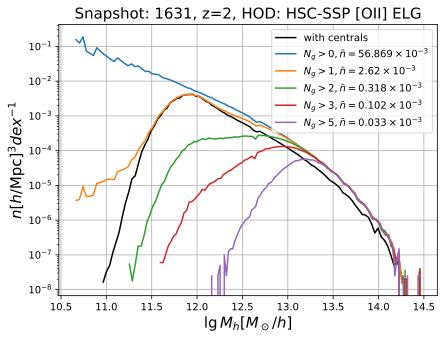

In [34]:
plt.figure(figsize = (6.8, 5))


label = galaxy_cata.get("halo_ind")[:galaxy_cata.N_cen]
y, x = np.histogram(lgM_h[label], bins = 100)
x = (x[1:]+x[:-1])/2
dx = x[1]-x[0]
n = len(label)/Boxlen**3
plt.plot(x, y/Boxlen**3/dx, "k", label="with centrals")
richness = galaxy_cata.halo_richness
print(len(lgM_h))

for i in [0, 1, 2, 3, 5]:
    label = np.where(richness>=i)[0]
    print(len(label))
    y, x = np.histogram(lgM_h[label], bins = 100)
    x = (x[1:]+x[:-1])/2
    dx = x[1]-x[0]
    n = len(label)/Boxlen**3
    plt.plot(x, y/Boxlen**3/dx, label="$N_g>"+str(i)+r", \bar n="+str(np.round(n*10**3, 3))+r"\times 10^{-3}$")
plt.yscale("log")
plt.ylabel(r"$n[h/{\rm Mpc}]^3 dex^{-1}$", fontsize = 15)
plt.xlabel("$\lg M_h [M_\odot/h]$", fontsize = 15)
plt.grid()
plt.legend()
plt.title("Snapshot: 1631, z=2, HOD: HSC-SSP [OII] ELG", fontsize = 15)

/opt/conda/conda-4.12.0/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


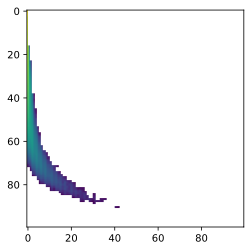

In [74]:
H, xedges, yedges = np.histogram2d(lgM_h, galaxy_cata.halo_richness, bins=100)
plt.imshow(np.log10(H))

[0.         0.0268526  0.05370521 0.08055781 0.10741042 0.13426302
 0.16111563 0.18796823 0.21482084 0.24167344 0.26852605 0.29537865
 0.32223125 0.34908386 0.37593646 0.40278907 0.42964167 0.45649428
 0.48334688 0.51019949 0.53705209]
[0.0015754  0.02330917 0.04504295 0.06677672 0.08851049 0.11024427
 0.13197804 0.15371181 0.17544559 0.19717936 0.21891313 0.24064691
 0.26238068 0.28411445 0.30584823 0.327582   0.34931577 0.37104955
 0.39278332 0.41451709 0.43625087]
[0.         0.01850851 0.03701702 0.05552553 0.07403403 0.09254254
 0.11105105 0.12955956 0.14806807 0.16657658 0.18508509 0.2035936
 0.2221021  0.24061061 0.25911912 0.27762763 0.29613614 0.31464465
 0.33315316 0.35166167 0.37017017]


/opt/conda/conda-4.12.0/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


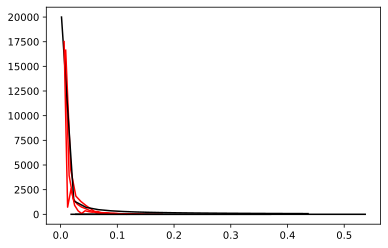

In [103]:
label = np.where(lgM_h>14.3)[0]
halo_ind = galaxy_cata.get("halo_ind")
pos_rel = galaxy_cata.get("gal_pos_rel")
for i in label:
    label_i = np.where(halo_ind==i)[0]
    #print(label_i, len(label_i))
    pos_rel_i = pos_rel[label_i,:]
    length_i = np.sqrt(np.sum(pos_rel_i**2, axis=1))
    p_r, r = np.histogram(length_i, bins=20)
    print(r)
    plt.plot(r[1:]/(1+2), p_r/r[1:]**2, "r")
    
    conc = concentration.concentration(10**lgM_h[label[i]], 'vir', 2, model = 'bullock01')
    p_nfw = profile_nfw.NFWProfile(M = 10**lgM_h[label[i]], c = conc, z = 2, mdef = 'vir') 
    plt.plot(r, p_nfw.density(r)/p_nfw.density(r)[0]*20000, "k")
    #print(p_nfw.density(r))
    
#plt.ylim(0, 30)
    

In [ ]:
deng=den_NGP(p,Grid)

[[10.         10.26315789 10.52631579 10.78947368 11.05263158 11.31578947
  11.57894737 11.84210526 12.10526316 12.36842105 12.63157895 12.89473684
  13.15789474 13.42105263 13.68421053 13.94736842 14.21052632 14.47368421
  14.73684211 15.        ]
 [10.         10.26315789 10.52631579 10.78947368 11.05263158 11.31578947
  11.57894737 11.84210526 12.10526316 12.36842105 12.63157895 12.89473684
  13.15789474 13.42105263 13.68421053 13.94736842 14.21052632 14.47368421
  14.73684211 15.        ]
 [10.         10.26315789 10.52631579 10.78947368 11.05263158 11.31578947
  11.57894737 11.84210526 12.10526316 12.36842105 12.63157895 12.89473684
  13.15789474 13.42105263 13.68421053 13.94736842 14.21052632 14.47368421
  14.73684211 15.        ]
 [10.         10.26315789 10.52631579 10.78947368 11.05263158 11.31578947
  11.57894737 11.84210526 12.10526316 12.36842105 12.63157895 12.89473684
  13.15789474 13.42105263 13.68421053 13.94736842 14.21052632 14.47368421
  14.73684211 15.        ]
 [10

/opt/conda/conda-4.12.0/envs/python3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=18,15 m=200 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


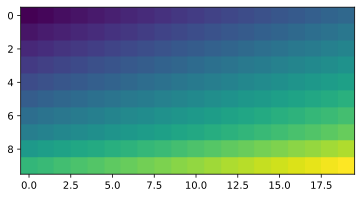

In [27]:
n_bin_lgM=20
n_bin_lgu=10
n_bin_lgr=10
redshift =2
        
lgM_s = np.linspace(10,  15, n_bin_lgM)
lgr_s = np.linspace(-10,  0, n_bin_lgr) #/r_vir
lgu_s = np.linspace(-5, 0, n_bin_lgu)

lgr_2d = np.zeros((len(lgu_s), len(lgM_s)))

from colossus.halo import profile_nfw
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw

cosmology.setCosmology('planck18')
for i in range(n_bin_lgM):
    p_nfw = profile_nfw.NFWProfile(M = 10**lgM_s[i], c = 10.0, z = redshift, mdef = 'vir') 
    r_vir = p_nfw.RDelta(z=redshift, mdef ="vir") #float kpc/h
    enclose_mass = p_nfw.enclosedMass(10**lgr_s*r_vir)  #len(r), r kpc/h
    lgu = np.log10(enclose_mass/enclose_mass[-1]) #len(r)
    f = interp1d(lgu, lgr_s+np.log10(r_vir))
    #print(r_vir, (lgr_s+np.log10(r_vir)))
    #plt.plot(lgu, lgr_s+np.log10(r_vir))
    lgr_2d[:,i] = f(lgu_s)
xx, yy = np.meshgrid(lgM_s, lgu_s)
print(xx, yy, 10**lgr_2d)
f = interp2d(xx, yy, lgr_2d-3)
plt.imshow(lgr_2d)

#f = interp2d(lgu, lgM_s.reshape(1, -1)*np.ones((len(lgr_s), 1)), lgr_s, bounds_error=False, fill_value=0)
        

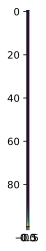

In [115]:
plt.imshow(lgu)

# 2012.12224 ELG HSC

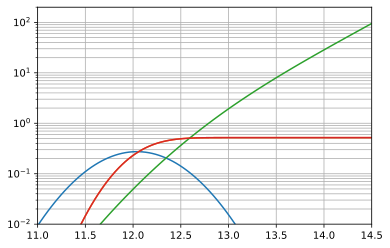

In [ ]:
model = "NB816"
#model = "NB912"
if model == "NB816":
    lgM_c = 11.75
    lgM_min = 12.46
    sigma_lgM = 0.06
    alpha = 1.06
    F_c_A = 0.13
    F_c_B = 0.95
    F_s = 0.98
    f_fake = 0.172
    
    lgM_c = 12.04
    lgM_min = 12.61
    sigma_lgM = 0.4
    alpha = 1.03
    F_c_A = 0.26
    F_c_B = 0.37
    F_s = 0.54
    f_fake = 0.14
if model == "NB912":
    lgM_c = 11.93
    lgM_min = 12.47
    sigma_lgM = 0.13
    alpha = 1.23
    F_c_A = 0.14
    F_c_B = 0.9
    F_s = 0.73
    f_fake = 0.128    
    #'''
    lgM_c = 11.91
    lgM_min = 12.57
    sigma_lgM = 0.17
    alpha = 1.12
    F_c_A = 0.26
    F_c_B = 0.53
    F_s = 0.55
    f_fake = 0.104

from scipy import special
def cal_N_cen(lgM):
    term_gaussian = F_c_B*(1-F_c_A)*np.exp(-(lgM-lgM_c)**2/2/sigma_lgM**2)
    term_step = F_c_A * (1+special.erf((lgM-lgM_c)/sigma_lgM))
    plt.plot(lgM, term_gaussian)
    plt.plot(lgM, term_step)
    
    return term_step
    return term_gaussian#+term_step
def cal_N_sat(lgM):
    delta_lgM = 1
    N_sat =  F_s * (1+special.erf((lgM-lgM_min)/delta_lgM))*(10**(lgM-lgM_min))**alpha
    plt.plot(lgM, N_sat)
    return N_sat

lgM = np.linspace(11,14.5,100)
N_cen = cal_N_cen(lgM)
N_sat = cal_N_sat(lgM)
plt.plot(lgM, N_cen)
plt.xlim(11,14.5)
plt.ylim(0.01,200)
plt.yscale("log")
plt.grid(which="Both")

# luminosity function (2003.06394)

In [73]:
def cal_Phi_true(lgL, z):
    lgPhi_star_0 = -1.89 
    gamma = -1.96
    epsilon = -2.48
    z_pivot = 1
    lgL_star_0 = 40.73
    beta = 2.61
    alpha = -1.25
    
    #dlgL = lgL[1]-lgL[0]
    Phi_star_0 = 10**lgPhi_star_0
    L = 10**lgL
    L_star_0 = 10**lgL_star_0
    

    def Phi_star_z():
        if z<=z_pivot:
            return Phi_star_0 * (1+z)**gamma
        else:
            return Phi_star_0 * (1+z_pivot)**(gamma+epsilon)*(1+z)**(-epsilon)
    dn_lgL= Phi_star_z() * (L/L_star_0/(1+z)**beta)**alpha * np.exp(-L/L_star_0/(1+z)**beta)* L/L_star_0/(1+z)**beta * np.log(10)
    print(Phi_star_z())
    return dn_lgL

0.01095414397035632


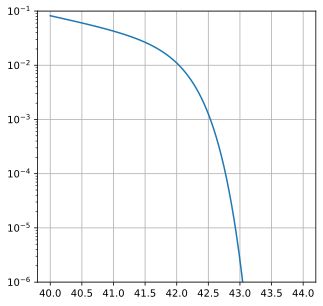

In [79]:
plt.figure(figsize=(5,5))
lgL = np.linspace(40, 44, 100)
phi_true = cal_Phi_true(lgL=lgL, z = 2.24) 
plt.plot(lgL, phi_true)
plt.yscale("log")
plt.ylim(10**-6, 0.1)
plt.grid()


In [22]:
np.exp(1)

2.718281828459045

In [ ]:
class HOD_ELG:
    def __init__(Ac, As, mu, lgM0, lgM1, sigma, alpha, gamma, ):
        self.Ac = Ac
        self.As = As
        self.mu = mu
        self.lgM0 = lgM0
        self.lgM1 = lgM1
        self.sigma = sigma
        self.alpha = alpha
        self.gamma = gamma
        
        
    def N_sat_M(lgM):
        return self.As*((10**self.lgM-10**self.lgM0)/10**self.lgM1)**self.alpha
    
    def N
    